In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important;} </style>"))

import numpy as np
import pandas as pd
from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers
import matplotlib.pyplot as plt

# Table of contents

* [I - Algorithms for quadratic programming ](#sec1)
    * [1. The active set method](#sec1_1)
* [II - Application of quadratic programming-SVM ](#sec_2)

# I - Algorithms for quadratic programming

The **quadratic programming(QP)** problems are linearly constrained optimization problems with a quadratic objective function.

$$ (QP)
\begin{cases}
\min_{x} f(x) := \min_{x}(\frac{1}{2}x^THx + c^Tx)\\
s.t. g(x): = Ax - b \geq0
\end{cases}
$$

Suppose $H\in\mathbb{R^{n\times n}}$ is symmetric postive semidefinite, $c\in\mathbb{R^n}$, $A\in\mathbb{R^{m\times n}}$, $b\in\mathbb{R^{m}}$, with $A = (a_1^T, a_2^T, ... a_m^T), b=(b_1, b_2, ... b_m)$, and the feasible region $\mathcal{F} := \{x\in\mathbb{R^n}|Ax\geq b\}$


The **Karush-Kuhn-Tucker(KKT) condition** for the above QP problem is:

A point $x^* \in \mathcal{F} $ is a minimiser to problem (QP) $\Longleftrightarrow$ $\exists \lambda,\mu\in\mathbb{R_{+}^{m}}$ with

$$
\begin{align}
(Lagrange\quad function)&\nabla f(x^*) + \Sigma_i\lambda_i\nabla g(x^*) = Hx^*+c+A^T\lambda = 0 \\
(Complementary\quad slackness)& Ax^*+\mu = b\\
& \lambda^T\mu = 0
\end{align}
$$

## I-1 The active set method for solving QP <a class='anchor' id='sec1'></a>

From the KKT condition we learn that if we can find the active constraint $\mathcal{A(x^*)}$set then we can remove the inequality constraints to solve a easier problem. However it is generally difficult to pre-determined the $\mathcal{A(x^*)}$. The principal of active set method is to iterate to obtain a list of $A(x^k)$ by solving sub QP problem to approach the result. It is proved that the number of iterations $k$ is limited. Furthermore with the duality we know that if the lagrange coefficient $\lambda \geq 0$, the optimum is obtained and the iteration can be stopped. So it reduce to construct the iteration to obtain $x^k$

Note $x = x^k+\delta x$ where $\delta x$ is the direction to move for next iteration, the above mentioned QP problem is to find the optimum for 

$$
\begin{cases}
\min_{\delta x}f(x^k+\delta x) = \min_{\delta x}\frac{1}{2}(x^k+\delta x)^TH(x^k+\delta x)+ c^T(x^k+\delta x)\\
s.t. a_{i}^T(x^k+\delta x) = b_{i}, i\in\mathcal{A(x^k)}
\end{cases}
$$

By expanding the above equation and taking account that $f(x^k)$ can be thought as a constant the above optmisation problem can be reformulated as:

$$
\begin{cases}
\min_{\delta x} f'(x^k)\delta x+ \frac{1}{2}f"(x^k)\delta x^2 = \frac{1}{2}\delta x^TH\delta x + (Hx^k+c)\delta x\\
s.t. a_{i}^T\delta x = 0, i\in\mathcal{A(x^k)}
\end{cases}
$$

Note $\delta x^k$ the optimum solution for the above problem, if $\delta x^k$ is not zero, then we get an direction for the objective function to descend, then we need to find out a step lenghth $\alpha_k$, if for all $i$, $x^k+\delta x^k (\alpha_k =1)$ satisfies the original (QP) 's constraint, then it's OK to have $\alpha_k=1$, otherwise $\alpha_k$ should be less than 1 to keep the next step $x^{k+1} = x^k+\alpha_k \delta x^k$ within the feasible regions.

As $\delta x^k$ is obtained with the constraint in $\mathcal{A(x^k)}$, $x^{k+1}$ naturally meets the constraints in $\mathcal{A(x^k)}$, we only need to check the rest of constraints: for $i\notin \mathcal{A(x^k)}$ we should have $a^T_{i}(x^k+\alpha_k\delta x^k) \geq b_i$, notice also that if $a_i^T\delta x^k\geq0$ than taking $\alpha_k>0$ can meet all constraints, which means we only need to pay attention to the case $a_i^Tx^k\lt0$, so that we have the following condition for $\alpha_k$

$$\alpha_k \leq \frac{b_i-a_i^Tx^k}{a_i^T\delta x^k}, \alpha_k=min(1, \min_{i \notin\mathcal{A(x^k)}, a_i^T\delta x^k \lt 0}\frac{b_i-a_i^Tx^k}{a_i^T\delta x^k})$$

The above expression can be used to obtain $\alpha_k$, however the calculation can be costly if we update the ($\mathcal{A^k}$) for multiple change. In fact, every constraint has a minimum $\alpha_k$ to suit the constraint, if $\alpha_k<1$ then the constraint can be thought of as 'blocking' the objective function to descend, than we can add it back to the active set: $\mathcal{A(x^k+1)} = \mathcal{A(x^k)} \cup {r}$, where $r$ is found by 

$$\alpha_k = min_{i \notin\mathcal{A(x^k)}, a_i^T\delta x^k \lt 0}\frac{b_i-a_i^Tx^k}{a_i^T\delta x^k}) = \frac{b_r-a_r^Tx^k}{a_r^T\delta x^k}$$

if $\alpha_k =1$, it means there is no blocking constraint we keep the current active set and check the postiveness of lagrange coefficients.

Below is an illustration of active set method ($p$ is the $\delta x$ in previous description)

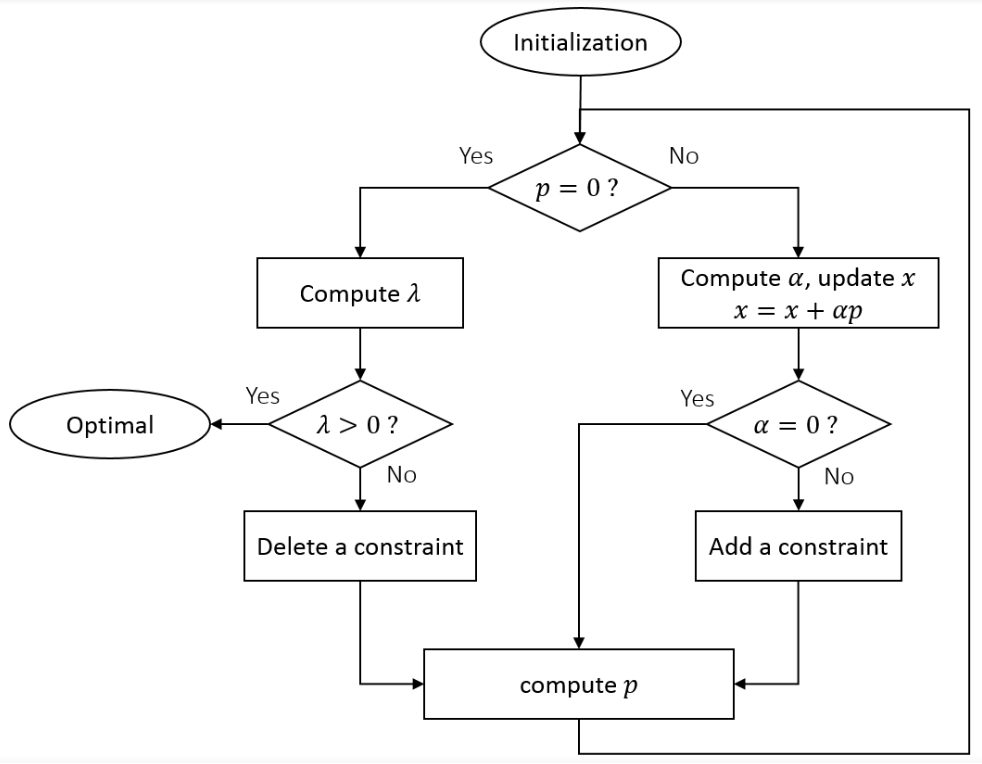

In [71]:
from IPython.display import Image, display

display(Image(filename='snap.png'))

In [73]:
# Active set
# min 1/2x.THx+c.Tx
# s.t. Ax>=b

class Active_set(object):
    def __init__(self, H, c, A, b):
        """
        params: H, c, A, b defined as the same in QP problem, epsilon the tolerance to test positive value
        """
        self.H = H
        self.c = c
        self.A = A
        self.b = b
        self.epsilon = 1e-6

    def initial_set(self, given=True):
        """
        Initialize the active constraint set for the special testing case
        # simple case if the first constraint is satified and all other constraints are satisfied also
        """
        if given:
            # Choose the active contraint by simply taking the first
            # Find the x0 that satisfy the first constraint in active set
            # Find the first coefficient in the chosen constraint that is not zero, let the element of x be b/coeff 
            # to satisfy the ax>=b and set other element simply to be zero
            active_set_rows = [0]

            index = np.where(self.A[0] != 0)[0][0]
            value = self.A[0][index]
            feasible_x = np.zeros(len(self.A[0]))
            feasible_x[index] = self.b[0][0]/float(value)

            feasible_x = feasible_x.reshape(-1, 1)
            return active_set_rows, feasible_x
        else:
            # TODO: implement method to solve linear inequality functions
            pass
        

    def calculate_delta(self, x):
        """
        Calculate the first order derivative at x: f(x)
        """
        return np.matmul(self.H, x) + self.c

    def find_active_set(self):
        activate_set_rows, feasible_x = self.initial_set(given=True)
        steps = 0
        while True:
            steps += 1
            print("steps is {}".format(steps))

            # Calculate the derivative of f at current x, and the current active constraint set
            partial_x = self.calculate_delta(feasible_x)
            actual_A, actual_b, actual_b1 = find_new_data(self.A, self.b, activate_set_rows)
            # Solve for lagrangian for mu x = -delta f(x), with current active constraint
            delta = Lagrange(self.H, partial_x, actual_A, actual_b)
            solution = delta[0: self.H.shape[1]]
            # If we cannot find a descending direction
            if np.sum(np.abs(solution)) < self.epsilon:
                outcome = Lagrange(self.H, self.c, actual_A, actual_b1)
                lambda_value = outcome[self.H.shape[1]:].flatten()
                min_value = lambda_value.min()
                # if all lambda > 0 
                if min_value >= 0:
                    print("Reach Optimization")
                    print("Optimize x is {}".format(feasible_x.flatten()))
                    print("Active set is {}".format(activate_set_rows))
                    print("lambda_value is {}".format(lambda_value))
                    print("\n")
                    break
                # Desactivation
                else:
                    index = np.argmin(lambda_value)
                    activate_set_rows.pop(index)
                    feasible_x = feasible_x
                    print("Not Reach Optimization")
                    print("Feasible x is {}".format(feasible_x.flatten()))
                    print("Active set is {}".format(activate_set_rows))
                    print("lambda_value is {}".format(lambda_value))
                    print("\n")
            # if we can find out the direction, then evaluate the step size    
            else:
                in_row, alpha_k = self.calculate_alpha(feasible_x, solution.reshape(-1, 1), activate_set_rows)
                if in_row == -1:
                    alpha = 1
                else:
                    alpha = min(1, alpha_k)

                feasible_x += alpha * solution
                # Activation
                if alpha != 1:
                    activate_set_rows.append(in_row)
                    print("Not Reach Optimization")
                    print("Feasible x is {}".format(feasible_x.flatten()))
                    print("Active set is {}".format(activate_set_rows))
                    print("\n")
                    continue
                else:
                    outcome = Lagrange(self.H, self.c, actual_A, actual_b1)
                    lambda_value = outcome[self.H.shape[1]:].flatten()
                    min_value = lambda_value.min()
                    if min_value >= 0:
                        print("Reach Optimization")
                        print("Optimize x is {}".format(feasible_x.flatten()))
                        print("Active set is {}".format(activate_set_rows))
                        print("lambda_value is {}".format(lambda_value))
                        print("\n")
                        break
                    else:
                        index = np.argmin(lambda_value)
                        activate_set_rows.pop(index)
                        print("Not Reach Optimization")
                        print("Feasible x is {}".format(feasible_x))
                        print("Active set is {}".format(activate_set_rows))
                        print("lambda_value is {}".format(lambda_value))
                        print("\n")

    def calculate_alpha(self, x, d, activate_set_rows):
        """
        Calculate the step size param alpha
        """
        min_alpha = 0
        inrow = -1
        for i in range(self.A.shape[0]):
            if i in activate_set_rows:
                continue
            else:
                b_i = self.b[i][0]
                a_i = self.A[i].reshape(-1, 1)
                low_number = np.matmul(a_i.T, d)[0][0]
                if low_number >= 0:
                    continue
                else:
                    new_alpha = (b_i - np.matmul(a_i.T, x)[0][0])/float(low_number)
                    if inrow == -1:
                        inrow = i
                        min_alpha = new_alpha
                    elif new_alpha < min_alpha:
                        min_alpha = new_alpha
                        inrow = i
                    else:
                        continue
        return inrow, min_alpha


def Lagrange(H, c, A, b):
    # construct the lagrange matrix and solve it
    #   |  H  -A.T  |   |  wx  |   | -c |
    #   |           | * |      | = |   |
    #   |  A   0   |   |  wl  |   |-b  |
    up_layer = np.concatenate((H, -A.T), axis=1)
    zero_0 = np.zeros([A.shape[0], A.shape[0]])
    low_layer = np.concatenate((-A, zero_0), axis=1)
    lagrange_matrix = np.concatenate((up_layer, low_layer), axis=0)

    actual_b = np.concatenate((-c, -b), axis=0)
    lagrange_matrix_inverse = np.linalg.inv(lagrange_matrix)
    return np.matmul(lagrange_matrix_inverse, actual_b)


def find_new_data(A, b, activate_set_rows):
    # Update active constraint
    actual_A = A[activate_set_rows]
    actual_b = np.zeros_like(b[activate_set_rows])
    return actual_A, actual_b, b[activate_set_rows]


if __name__ == "__main__":
    
    """
    Example 5 of page 171 from chapter 4.2
    
    f(x) = x1^2 - x1x2 + x2^2 - 3x1
    constraints:
    -x1-x2>= -2
    x1 >= 0
    x2 >= 0
    -x1 >= -3/2
    
    thus we have
    H = np.array([ [2.0, -1], [-1, 2.0] ])
    c = np.array([ [-3.0], [0.0]]).reshape(-1,1)
    A = np.array([ [-1.0, -1.0], [1.0, 0],[0, 1],[-1.0, 0.0]])
    b = np.array( [ [-2.0], [0], [0], [-3/2] ] ).reshape(-1,1)
    
    The optimal is obtained at x = [x1, x2] = [1.5, 0.5]
    
    """
    
    H = np.array([ [2.0, -1], [-1, 2.0] ])
    c = np.array([ [-3.0], [0.0]]).reshape(-1,1)
    A = np.array([ [-1.0, -1.0], [1.0, 0],[0, 1],[-1.0, 0.0]])
    b = np.array( [ [-2.0], [0], [0], [-3/2] ] ).reshape(-1,1)

    test = Active_set(H, c, A, b)
    test.find_active_set()


steps is 1
Reach Optimization
Optimize x is [1.5 0.5]
Active set is [0]
lambda_value is [0.5]




# II - Application: SVM <a class='anchor' id='sec2'></a>

In a simpliest case of Support Vector Machine(SVM) to seperate points $x_i\in\mathbb{R}^{n}$ to value $y_i\in\{-1, 1\}$with a hyperplane described by  $<\omega, x>+\beta=0$, the condtion can be set as $<\omega, x_i>+\beta\geq1$ if $y_i=1$ and $<\omega,x_i>+\beta\leq-1$ if $y_i=-1$, $i\in\{1,...,m\}$. This classification problem can be described as an optimisation problem by finding the maximum 'margin' distance $2/\sqrt{<\omega, \omega>}$ between the two hyperplances $<\omega, x>+\beta=1$ and $<\omega, x>+\beta=-1$ then be formulated as

If the two classes are linearly separateble:
$$
(QP-linearly\;seperatable)=\begin{cases}
\min\limits_{\omega}\frac{1}{2}<\omega, \omega>\\
y_i(<\omega, x_i>+\beta)\geq1 (i=\{1,...m\})
\end{cases}
$$

If the two classes are not linearly separatable, we can introduce a nonnegative penalties $\xi_{i}$ as "soft" margin :
$$
(QP-no\;linearly\;seperatable) = \begin{cases}
\min\limits_{\omega}\frac{1}{2}<\omega, \omega> + C\sum\limits_{i=1}^{m}\xi_{i}\\
y_i(<\omega, x_i>+\beta)\geq1-\xi_{i} (i=\{1,...m\})
\end{cases}
$$




In [2]:
# Read breast-cancer-diagnostic csv files
data = pd.read_csv('breast-cancer-wisconsin.data', header=None)

# Adjust column names
headers = ['ID', 'Clump Thickness+A20', 'Uniformity of Cell Size', 'Uniformity of Cell Shape', 'Marginal Adhesion',
          'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin', 'Normal Nucleoli', 'Mistoses', 'Class']
data.columns = list(map(lambda x: x.replace(" ", '_'), headers))

# Data cleaning
data = data[data['Bare_Nuclei']!="?"].astype(int) # remove missing value lines
data = data.drop(["ID"], axis=1) # drop ID column
data['Class'] = np.where(data['Class']==2,1,-1) # Adjust labels

# Split data into training set and testing set
training_data = data[:120]
training_data_X = training_data.iloc[:,:9]
training_data_y = training_data.iloc[:,-1]

testing_data = data[120:]
testing_data_X = testing_data.iloc[:,:9]
testing_data_y = testing_data.iloc[:,-1]

# Initialize values and computing the input params
X = training_data_X.to_numpy()
y = training_data_y.to_numpy()

C = 1000
m, n = X.shape
y = y.reshape(-1,1)*1.
X_dash = y*X
H = np.dot(X_dash, X_dash.T)*1.

# Converting the input into cvxopt format
P = cvxopt_matrix(H)
q = cvxopt_matrix(-np.ones((m,1)))
G = cvxopt_matrix(np.vstack((np.eye(m)*-1, np.eye(m))))
h = cvxopt_matrix(np.hstack((np.zeros(m), np.ones(m)*C)))
A = cvxopt_matrix(y.reshape(1,-1))
b = cvxopt_matrix(np.zeros(1))

# Run solver
sol = cvxopt_solvers.qp(P, q, G, h, A, b)
lambdas = np.array(sol['x'])

# Computing and printing params
w = ((y * lambdas).T @ X).reshape(-1,1)
S = (lambdas > 1e-4).flatten()
b = y[S] - np.dot(X[S], w)

# Display results
print('Lambdas = ', lambdas[lambdas > 1e-4])
print('w = ', w.flatten())
print('b = ', b[0])


# Evaluate the performance of the classifier
def classifier(w, x, b):
    return np.sign(np.dot(w, x)+b)

# Set w and beta
W = w.flatten()
beta = b[0]


# Run classifier
testing_data['Prediction'] = testing_data_X.apply(lambda x: classifier(W,x,beta), axis=1).astype(int)

result = np.where(testing_data['Class'] == testing_data['Prediction'], 0, 1)

print("TP = {}, T")
print("Error rate = ", round((1-sum(result)/len(result))*100, 3), "%")


     pcost       dcost       gap    pres   dres
 0:  1.6906e+03 -5.2157e+07  1e+08  5e-01  1e-10
 1:  3.7354e+04 -1.5377e+07  3e+07  8e-02  1e-10
 2:  7.5108e+04 -4.5746e+06  7e+06  2e-02  1e-10
 3:  5.7151e+04 -1.4167e+06  2e+06  4e-03  1e-10
 4:  4.3432e+03 -1.5789e+05  2e+05  1e-04  1e-10
 5: -3.5501e+03 -3.5288e+04  3e+04  9e-13  9e-11
 6: -3.7995e+03 -1.4052e+04  1e+04  7e-13  1e-10
 7: -4.2746e+03 -1.0660e+04  6e+03  1e-12  1e-10
 8: -4.3824e+03 -7.7619e+03  3e+03  6e-14  1e-10
 9: -4.7497e+03 -6.9636e+03  2e+03  5e-13  1e-10
10: -4.8098e+03 -6.6127e+03  2e+03  7e-13  1e-10
11: -5.2507e+03 -5.5924e+03  3e+02  6e-13  2e-10
12: -5.3545e+03 -5.3945e+03  4e+01  3e-13  1e-10
13: -5.3602e+03 -5.3820e+03  2e+01  7e-13  1e-10
14: -5.3618e+03 -5.3805e+03  2e+01  1e-13  1e-10
15: -5.3689e+03 -5.3692e+03  3e-01  2e-16  1e-10
16: -5.3690e+03 -5.3690e+03  3e-03  1e-13  1e-10
Optimal solution found.
Lambdas =  [9.99999998e+02 9.99999894e+02 9.24249222e-04 2.01519414e+02
 2.92835862e+02 1.29625

/var/folders/xq/0m5kmmjd17713s0vsd94b6wc0000gn/T/ipykernel_74636/941860226.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_data['Prediction'] = testing_data_X.apply(lambda x: classifier(W,x,beta), axis=1).astype(int)


In [7]:
testing_data[testing_data['Class'] == -1 & (testing_data['Prediction']==-1)]

,Clump_Thickness+A20,Uniformity_of_Cell_Size,Uniformity_of_Cell_Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mistoses,Class,Prediction
196,8,4,4,5,4,7,7,8,2,1,-1
252,6,3,3,5,3,10,3,5,3,1,-1
494,5,1,2,10,4,5,2,1,1,1,-1
